This notebook considers the value uplift of using machine learning to improve pre-drill geological chance of success (Pg) estimates. Machine learning attributes can better discriminate against dry holes and successes based on analysis of geophysical attributes. 
The code workflow is to define histograms for baseline and machine learning (ml) distributions of dry holes and discoveries in a hypothetical exploration prospect inventory.
Next, prospect characteristics are modeled using monte-carlo simulation based on lognormal resource distributions.
The modeled portfolio is sorted according to highest pre-drill risked resource. Prospects are drilled (sampled from lognormal distribution) based on the sorted dispatch order.
Several hundred realizations are averaged for the aggregate comparison of portfolio value based on the underlying pre-drill Pg distributions. 
Results indicate that more accurate pre-drill discrimination between dry holes and successes leads to better portfolio optimization.
Maximum value can be attatined after only 25 wells as opposed to 48 wells in the baseline distribution.

In [1]:
#Import libraries

%load_ext autoreload
%autoreload 2

from tqdm import tqdm

import pandas as pd
import numpy as np
import scipy.stats

import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.patches as mpatches


In [2]:
# Import Definitions
from src.definitions import ROOT_DIR
from src.definitions import list_Pg, list_PgML
# Load Helper Functions
from src.data.utils import realization, portfolio_simulation, kernel_generator

In [11]:
#Bins for histogram generation
bins = np.arange(0,10.5, .5)/10
bins

array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
       0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ])

In [12]:
# %% Baseline Probability Distribution
list_Pg = [0,0,.3,.33,.45,.5,.45,.75,.8,.8,.83,1,1,1,1,0,0,0,0,0]
list_Pf = [1-i for i in list_Pg]
bin_count_base = [0,1,3.5,7.5,5.5,5,5.5,4,2.5,1.25,.6,.5,.4,.25,.2,0,0,0,0,0]
bin_count_base = [int(i * 100) for i in bin_count_base]
#multiply the overall prospect count by the chance of success to split out two distributions
bin_count_discovery = [i*j for i, j in zip(list_Pg,bin_count_base)]
bin_count_dryhole = [i*j for i, j in zip(list_Pf, bin_count_base)]

In [5]:
# %% Probability Distribution with Machine Learning
list_PgML = [0,0,0,0,.05,.06,.09,.2,.3,.45,.53,.58,.8,.89,.93,.98,1,1,1,0]
list_PfML = [1-i for i in list_PgML]
bin_count_ML = [0,.2,.5,1.25,2.1,2.65,2.75,2.5,2.5,2.75,2.85,3,2.5,2.25,2.3,2.05,1.85,1,.5,0]
bin_count_ML = [int(i * 100) for i in bin_count_ML]
bin_count_discovery_ML = [i*j for i, j in zip(list_PgML,bin_count_ML)]
bin_count_dryhole_ML = [i*j for i, j in zip(list_PfML, bin_count_ML)]

In [13]:
# %% Use helper function "kernel_generator" to generate baseline success/dryhole and machine learning success/dry hole
hist_baseline_discovery = kernel_generator(bins=bins, bin_counts=bin_count_discovery)
hist_baseline_dryhole = kernel_generator(bins=bins, bin_counts=bin_count_dryhole)
hist_ml_discovery = kernel_generator(bins=bins, bin_counts=bin_count_discovery_ML)
hist_ml_dryhole = kernel_generator(bins=bins, bin_counts=bin_count_dryhole_ML)

In [14]:
# %% baseline portfolio values simulated based on histogram kernels
baseline_resource = portfolio_simulation(num_simulations=500, num_prospects=25, hist_discovery=hist_baseline_discovery,
                                         hist_dryhole=hist_baseline_dryhole,value_dollar=False)

baseline_value = portfolio_simulation(num_simulations=500, num_prospects=25, hist_discovery=hist_baseline_discovery,
                                         hist_dryhole=hist_baseline_dryhole,value_dollar=True)

In [15]:
# %%machine learning portfolio simulated based on histogram kernels
ml_resource = portfolio_simulation(num_simulations=500, num_prospects=25, hist_discovery=hist_ml_discovery,
                                         hist_dryhole=hist_ml_dryhole,value_dollar=False)

ml_value = portfolio_simulation(num_simulations=500, num_prospects=25, hist_discovery=hist_ml_discovery,
                                         hist_dryhole=hist_ml_dryhole,value_dollar=True)

In [17]:
#portfolio values are based on ranking the pre-drill risked resource expectation for each realization and then
#modeling the actual outcome based on a lognormal distribution
ml_resource_uplift = ml_resource -baseline_resource
ml_value_uplift = ml_value - baseline_value
#due to better pre-drill discrimination between dry holes and successes with the machine learning distribution, the machine learning
#portfolios are better optimized, enabling the best prospects to be drilled first and the worst to be avoided (Sorted to last) 

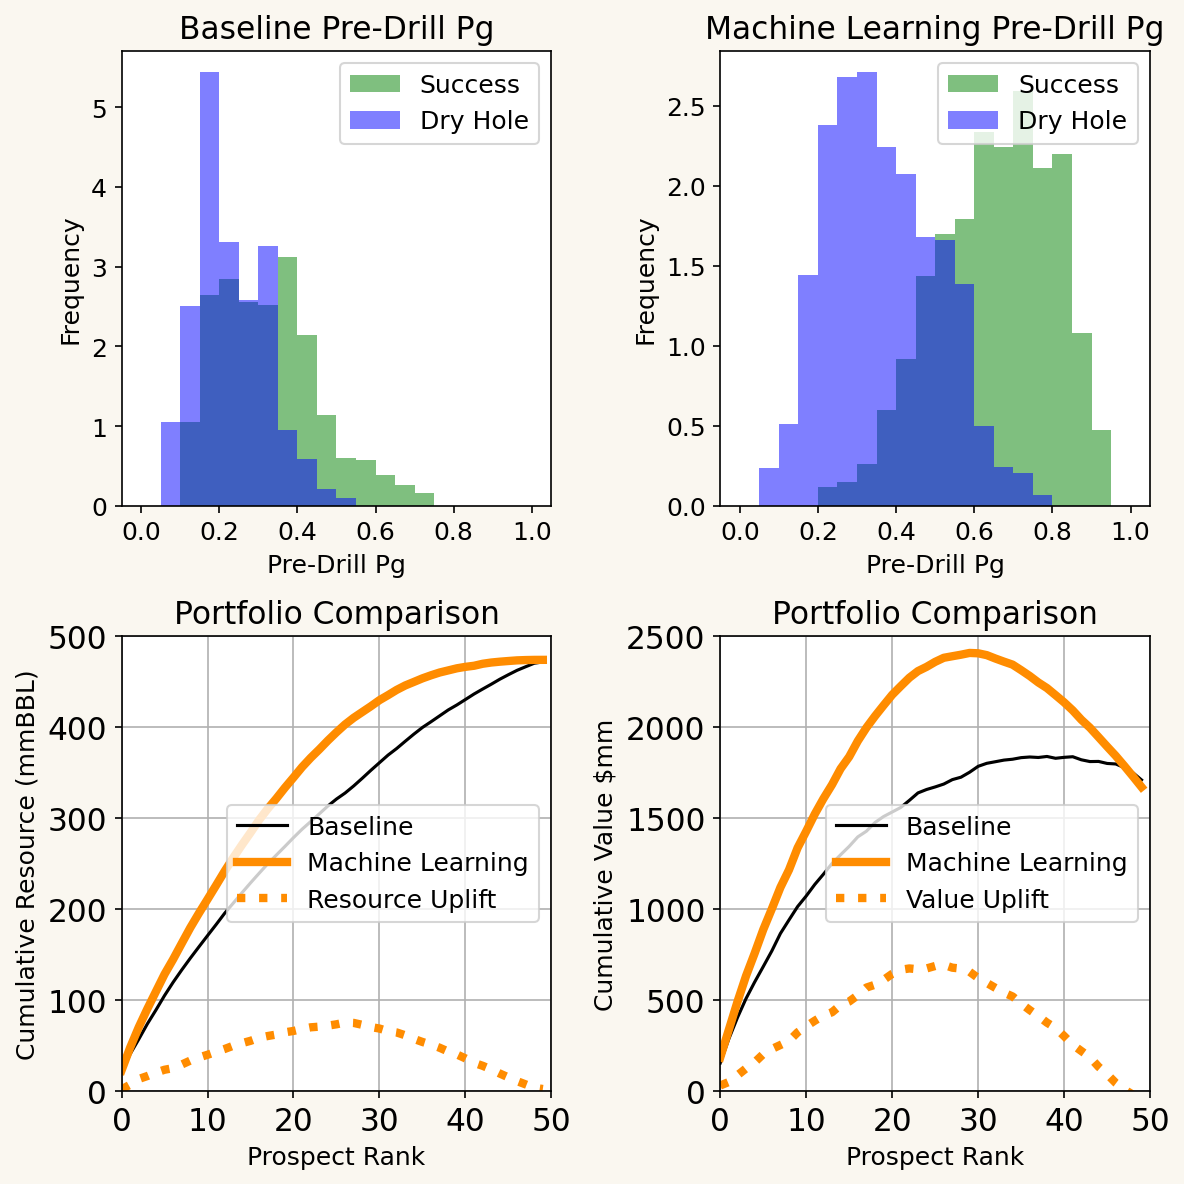

In [19]:
# %% Niven Plotting single
# Hist 1
rows = 2
cols = 2
fig, ax = plt.subplots(rows, cols, figsize=(8,8), facecolor=(0.98,0.97,0.94,1), dpi=150)
ax = plt.subplot(rows, cols, 1)
hist1 = plt.hist(hist_baseline_discovery.rvs(size=3500), bins=bins, density=True, alpha=.5, color='green',label='Success')
hist2 = plt.hist(hist_baseline_dryhole.rvs(size=3500), bins=bins, density=True, alpha=.5, color='blue', label='Dry Hole')
#plt.grid(axis='y', alpha=0.75)
ax = plt.xlabel('Pre-Drill Pg',fontsize=12)
ax = plt.ylabel('Frequency',fontsize=12)
ax = plt.xticks(fontsize=12)
ax = plt.yticks(fontsize=12)
ax = plt.title('Baseline Pre-Drill Pg',fontsize=15)
ax = plt.legend(fontsize=12)

# Hist 2
ax = plt.subplot(rows, cols, 2)
hist3 = plt.hist(hist_ml_discovery.rvs(size=3500), bins=bins, density=True, alpha=.5, color='green',label='Success')
hist4 = plt.hist(hist_ml_dryhole.rvs(size=3500), bins=bins, density=True, alpha=.5, color='blue', label='Dry Hole')
#plt.grid(axis='y', alpha=0.75)
ax = plt.xlabel('Pre-Drill Pg',fontsize=12)
ax = plt.ylabel('Frequency',fontsize=12)
ax = plt.xticks(fontsize=12)
ax = plt.yticks(fontsize=12)
ax = plt.title('Machine Learning Pre-Drill Pg',fontsize=15)
ax = plt.legend(fontsize=12)

# Resource Portfolio 
ax = plt.subplot(rows, cols, 3)
ax = plt.xlabel('Prospect Rank',fontsize=12)
ax = plt.ylabel('Cumulative Resource (mmBBL)',fontsize=12)
ax = plt.xticks(fontsize=15)
ax = plt.yticks(fontsize=15)
ax = plt.grid(True)
ax = plt.title('Portfolio Comparison',fontsize=15)
ax = plt.xlim(0, 50)
ax = plt.ylim(0, 500)
baseline = plt.plot(baseline_resource, label='Baseline', color='k')
ml = plt.plot(ml_resource, label='Machine Learning', color='darkorange', linewidth=4)
uplift = plt.plot(ml_resource_uplift, label='Resource Uplift', color='darkorange', linestyle=':', linewidth=4)
ax = plt.legend(fontsize=12, loc='right')

# Portfolio Value
ax = plt.subplot(rows, cols, 4)
ax = plt.xlabel('Prospect Rank',fontsize=12)
ax = plt.ylabel('Cumulative Value $mm',fontsize=12)
ax = plt.xticks(fontsize=15)
ax = plt.yticks(fontsize=15)
ax = plt.grid(True)
ax = plt.title('Portfolio Comparison',fontsize=15)
ax = plt.xlim(0, 50)
ax = plt.ylim(0, 2500)
baseline2 = plt.plot(baseline_value, label='Baseline', color='k')
ml2 = plt.plot(ml_value, label='Machine Learning', color='darkorange', linewidth=4)
uplift2 = plt.plot(ml_value_uplift, label='Value Uplift', color='darkorange', linestyle=':', linewidth=4)
ax = plt.legend(fontsize=12, loc='right')

fig.tight_layout()

Portfolio value using the machine learning distribution reaches a maximum after only 25 wells as opposed to needing to drill all 50.